# Proximity Effect Analysis for LPS dataset

This notebook contains all experiments relating to computing and characterizing cell proximity effects in the LPS dataset for T cells. It uses the spatial aging clocks to compute age acceleration for the analysis.

**Associated manuscript figures/tables:**
- Extended Data Figures: 10c

**Inputs required:**
- `results/clocks/anndata/allen_aging_lps_spatialsmooth_spage.h5ad` - AnnData object for LPS data with spatial aging clock predictions (generated from `4A_application_to_interventions.ipynb`)

**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

from ageaccel_proximity import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

## LPS Proximity Analysis

In [7]:
cutoff = {'brain ventricle': 34.945657872703606, 'corpus callosum': 24.93541068867991, 'cortical layer II/III': 25.962599056294216, 'cortical layer V': 26.37559593552028, 'cortical layer VI': 23.691288263852037, 'olfactory region': 26.61249396836906, 'pia mater': 34.800221767412104, 'striatum': 22.51435665983618}

In [8]:
adata = sc.read_h5ad("results/clocks/anndata/allen_aging_lps_spatialsmooth_spage.h5ad")
adata.obs["region"] = adata.obs["tissue"].copy()

# subset into old group
adata = adata[adata.obs.age==20.93]
adata.obs["cohort"] = adata.obs["cohort"].replace("aging", "control")

/local/scratch/edsun/slrmtmp.42755582/ipykernel_20749/765338297.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cohort"] = adata.obs["cohort"].replace("aging", "control")


In [9]:
# Check T cell proportions
print(np.sum((adata.obs.celltype=="T cell")&(adata.obs.cohort=="control"))/np.sum(adata.obs.cohort=="control"))
print(np.sum((adata.obs.celltype=="T cell")&(adata.obs.cohort=="lps"))/np.sum(adata.obs.cohort=="lps"))

0.0007992385879711542
0.000557013731232435


0.017436952139717743


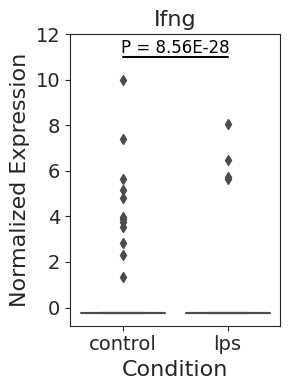

In [20]:
# Check expression of genes in T cells across conditions

signames = ["Ifng"]
marker_names = ["control", "lps"]
obs_key = "cohort"
celltype = "T cell"

exp_palette = {
    "lps":"#e75480", # forestgreen lightgreen
    "control":"#FEAF00"
}

pvalues = []
ustats = []

#-----------------------------

filtered_adata = adata[adata.obs.celltype==celltype]

for signame in signames:

    tag = signame

    sigvals = np.array(filtered_adata[:,signame].X).flatten()

    x_labels = np.concatenate([[x]*np.sum(filtered_adata.obs[obs_key]==x) for x in marker_names])
    y_values = np.concatenate([sigvals[filtered_adata.obs[obs_key]==x] for x in marker_names]).flatten()
    df = pd.DataFrame(np.vstack((x_labels,y_values)).T, columns=["label","expression"])
    df["expression"] = df["expression"].astype('float')

    fig, ax = plt.subplots(figsize=(3,4))

    sns.boxplot(df,x="label",y="expression",palette=exp_palette)

    # statistical annotation
    x_coords = [0.5]
    y_coords = [np.max(df["expression"])*1.1]
    cols = ['k']
    h = 0
    w = 0.5
    # get p-value from TISSUE results
    u, p = mannwhitneyu(df[df["label"]==marker_names[0]]["expression"],
                     df[df["label"]==marker_names[1]]["expression"])
    print(np.mean(df[df["label"]==marker_names[0]]["expression"])-np.mean(df[df["label"]==marker_names[1]]["expression"]))
    pvalues.append(p)
    ustats.append(np.mean(df[df["label"]==marker_names[0]]["expression"])-np.mean(df[df["label"]==marker_names[1]]["expression"]))
    pval_labels = [p]
    for i, label in enumerate(pval_labels):
        p_label = "P = "+ '%.2E' % Decimal(str(label))
        x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=12)
    plt.ylim([None,np.max(df["expression"])*1.2])

    plt.title(f"{signame}", fontsize=16)
    plt.ylabel(f"Normalized Expression Z-score", fontsize=16)
    plt.xlabel(f"Condition", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"plots/mechanism/lps_ViolinGene_{celltype}_{tag}_{method}.pdf",
               bbox_inches='tight')
    plt.show()

In [13]:
get_age_acceleration (adata)

In [14]:
# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

In [15]:
adata_celltypes = np.unique(adata.obs.celltype)

cell_pairs_to_show = []
for ct in ["T cell"]:
    for ct2 in [x for x in restricted_celltype_subset if x in adata_celltypes]:
        cell_pairs_to_show.append((ct, ct2))

In [16]:
condition = 'cohort'

####################################

cond_df = pd.DataFrame([])

cutoff_multiplier = 1

for celltype, ct in cell_pairs_to_show:
        
    for cond in np.unique(adata.obs[condition]):
        
        sub_adata = adata[(adata.obs["celltype"]==ct)&(adata.obs[condition]==cond)]

        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        near_freq = np.mean(near_ages=="Near")

        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct,
                          adata[adata.obs[condition]==cond], label=cond,
                          min_pairs=10)
        
        cond_df = pd.concat((cond_df, df))

In [17]:
# Create condition tags
map_cond = {
    "control": "Old Control",
    "lps": "Old LPS",
}
cond_df["label"] = [map_cond[x] for x in cond_df["label"]]
# re-order categories
cond_df['label'] = cond_df['label'].astype('category')
cond_df['label'].cat.reorder_categories(['Old Control', 'Old LPS'], inplace=True)


cond_df["Near Cell Conditioned"] = cond_df["Near Cell"].astype(str)+" ("+cond_df["label"].astype(str)+")"

/local/scratch/edsun/slrmtmp.42755582/ipykernel_20749/981082226.py:9: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  cond_df['label'].cat.reorder_categories(['Old Control', 'Old LPS'], inplace=True)


/local/scratch/edsun/slrmtmp.42755582/ipykernel_20749/1190486393.py:29: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.catplot(


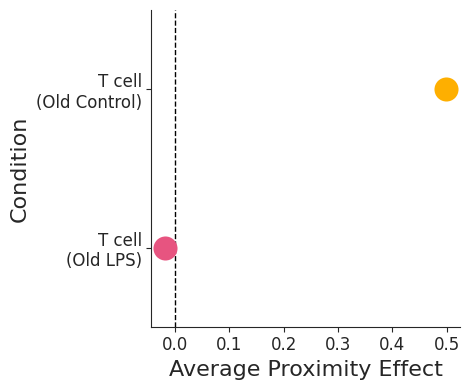

In [19]:
celltypes = []
average_effects = []
colors = []


effector_cells = ["T cell (Old Control)", "T cell (Old LPS)"]

sub_cond_df = cond_df[cond_df['Near Cell Conditioned'].isin(effector_cells)].copy()
sub_cond_df["Near Cell Conditioned"] = [x.split(" (")[0]+"\n("+x.split(" (")[1] for x in sub_cond_df["Near Cell Conditioned"]]


for ct in np.unique(sub_cond_df["Near Cell Conditioned"]):
    average_effect = np.nanmean(sub_cond_df[sub_cond_df["Near Cell Conditioned"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)


# Make Plot
palette = {
           "T cell\n(Old Control)":"#FEAF00",
           "T cell\n(Old LPS)":"#e75480"}

g = sns.catplot(
    x=average_effects,
    y=celltypes,
    palette=palette,
    s=300,
    order=["T cell\n(Old Control)", "T cell\n(Old LPS)"],
    height=4,
    aspect=1.2
)


plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Condition", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/proximity/lps_average_aging_effect_tcell.pdf",
           bbox_inches='tight')
plt.show()